## Learning Rate Scheduling
Learning rate is one of the most important hyperparameters when using optimization algorithms. However, finding the best learning rate can be a tricky task and requires a lot of effort.

If the learning rate is too high, the training process will diverge. On the other hand, if the learning is too low, the training process will take a very long time to converge to the optimum.

If the learning rate is slightly high, the traning process will be quick at first, but it will end up bouncing around the optimum (unless we're using adaptive optimization algorithms like AdaGrad, RMSProp or Adam).

In many cases, we may have to stop the training process early before it is converged properly. As a result, we may only find a suboptimal solution.


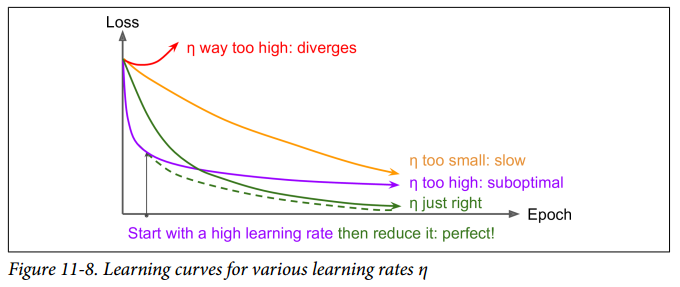

In [1]:
from IPython.display import Image
Image(filename='images/learning-rate-scheduling.png')

One way to find a good learning rate is Grid Search. However, using Grid Search on a *very* deep neural network would be very tedious and time-consuming. Another reason is that Grid Search only allows us to find a static (constant) learning rate, which is not optimal in many situations.

The idea behind **Learning Rate Scheduling** is that we start with a high learning rate and the reduce it once it stops making progress. There are a lot of methods to accomplish that task. Some of the most common ones are:

- **Predetermined piecewise constant learning rate**: For example, we can initialized the learning rate $\eta_0$ to 0.1, then $\eta_1$ to 0.001 after 50 epochs. This method may work well in many situations; however, it requires us to find the right list of learning rates and to apply each learning rate in the right time.
- **Performance scheduling**: measure the validation error every N steps (like early stopping) and reduce the learning rate by a factor of $\lambda$ when the error stops dropping.
- **Exponential scheduling**: set the learning rate to a function of the iteration number: $\eta(t) = \eta_0 * 10^{-t/r}$. The learning rate will drop by a factor of 10 every $r$ steps. This method works great, but it requires use to tune $\eta_0$ and $r$
- **Power scheduling**: set the learning rate to $\eta(t) = \eta_0(1 + t/r)^{-c}$. Hyperparameter $c$ is usually set to 1. This method is similar to Exponential scheduling but the learning rate drops much slowly.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

tf.reset_default_graph()
n_inputs = 784
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.elu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xen = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xen, name="loss")

Exponential Decay of the learning rate

```
decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
```

In [3]:
# Implement Learning Rate Scheduling in TensorFlow
# https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay
# Search for _decay in tf.train package for more learning rate scheduling methods
with tf.name_scope("train"):
    # The initial learning rate (eta_0 = 0.1)
    initial_learning_rate = 0.1
    
    # The number of training steps to reduce the learning rate (r = 10000)
    decay_steps = 10000
    
    # The learning rate reducing ratio
    decay_rate = 1/10
    
    # Create a nontrainable variable to keep track of the current training iteration number
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)
    
    # Create optimizer using decaying learning rate
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    
    # Create training operation in increment the number of training steps on the fly
    training_op = optimizer.minimize(loss, global_step=global_step)

We should not use Learning Rate Scheduling with adaptive optimization algorithms like AdaGrad, RMSProp or Adam as those algorithms will automatically reduce the learning rate during training.

In [4]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [5]:
init = tf.global_variables_initializer()
n_epochs = 100
batch_size = 100
mnist = input_data.read_data_sets("/tmp/data/")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(mnist.test.labels) // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
0 Train accuracy: 0.95 Test accuracy: 0.9161
1 Train accuracy: 0.95 Test accuracy: 0.9329
2 Train accuracy: 0.94 Test accuracy: 0.9485
3 Train accuracy: 0.97 Test accuracy: 0.9539
4 Train accuracy: 0.96 Test accuracy: 0.952
5 Train accuracy: 0.97 Test accuracy: 0.962
6 Train accuracy: 0.96 Test accuracy: 0.9609
7 Train accuracy: 1.0 Test accuracy: 0.9615
8 Train accuracy: 1.0 Test accuracy: 0.9639
9 Train accuracy: 0.99 Test accuracy: 0.9661
10 Train accuracy: 0.96 Test accuracy: 0.9683
11 Train accuracy: 1.0 Test accuracy: 0.9688
12 Train accuracy: 0.99 Test accuracy: 0.9701
13 Train accuracy: 0.97 Test accuracy: 0.9713
14 Train accuracy: 0.97 Test accuracy: 0.9734
15 Train accuracy: 0.98 Test accuracy: 0.9704
16 Train accuracy: 0.99 Test accuracy: 0.9744
17 Train accuracy: 0.99 Test accuracy: 0.97